# South Korea Total Monthly Exports Time Series Analysis and Forecast

South Korea is one of the Four Asian Tigers who has experienced high rates of economic growth since the 1960s, and it is mainly driven by exports.

In 2023, exports of goods and services made up 44% of South Korea's GDP and this showcases the signifiance of its contribution to its economic's growth.

We conduct a time series analysis on South Korea's exports to understand the underlying causes of trends and systemic patterns over time.

Additionally, we will build several time series model that can forecast the next 36 months of South Korea Total Exports to provide more certainity to its economy. 

Finally, we will compare the different models and select the one with the highest accuracy. 

## Source of Data

https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/erdm/mret

Download full time series as .csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from dateutil.parser import parse



In [2]:
ske = pd.read_csv("data/series-150824.csv")

The data is split into 3 main series, yearly, quarterly and monthly. We focus on the monthly data and use a function build our own monthly total exports dataframe.

In [3]:
def exports(series):
    series.rename(columns={'Title': 'Date', 'Trade in Goods: South Korea: Total: Exports: BOP: CP: SA': 'Total Exports'}, inplace=True)
    series['Date'] = pd.to_datetime(series['Date'])
    series = series.set_index('Date')
    series["Total Exports"] = series["Total Exports"].astype(int)
    return series

In [4]:
ske_M = exports(ske[144:474]) # Monthly Exports

/var/folders/h4/np0rkv4s6nz02qq6xsfrs1vc0000gn/T/ipykernel_20017/1881711894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.rename(columns={'Title': 'Date', 'Trade in Goods: South Korea: Total: Exports: BOP: CP: SA': 'Total Exports'}, inplace=True)
/var/folders/h4/np0rkv4s6nz02qq6xsfrs1vc0000gn/T/ipykernel_20017/1881711894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series['Date'] = pd.to_datetime(series['Date'])
/var/folders/h4/np0rkv4s6nz02qq6xsfrs1vc0000gn/T/ipykernel_20017/1881711894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [5]:
ske_M.head(20)

,Total Exports
Date,
1997-01-01,109
1997-02-01,98
1997-03-01,90
1997-04-01,101
1997-05-01,118
1997-06-01,120
1997-07-01,126
1997-08-01,110
1997-09-01,90


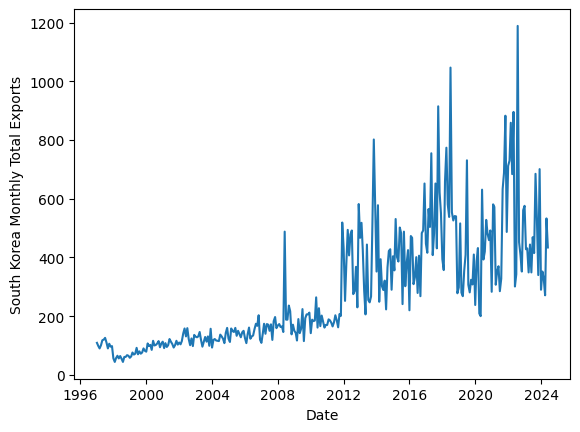

In [6]:
plt.xlabel("Date")
plt.ylabel('South Korea Monthly Total Exports')
plt.plot(ske_M)

#### From the time series plot, we can observe that the data is non-stationary as mean and variance is not constant. 

+ Stationarity means that the statistical properties of the time series data like mean and variance are constant over time. 

+ A stationary time series is independent of seasonal effects, it will not have any seasonal patterns. 

+ Therefore it can more accurately resemble a probability distribution rendering it easier to model

#### We check for stationarity using these methods:

+ Rolling statistics - rolling mean and rolling standard deviation 

+ ADF TEST

In [7]:
# Method 1: Rolling Statistics

rolmean = ske_M.rolling(window=12).mean()
# values of the 13th month is the mean of month 1-12
# values of the 14th month is the mean of month 2-13
rolstd = ske_M.rolling(window=12).std()
print(rolmean, rolstd) 
# our first 12 values will be NaN as we don't have any previous values

            Total Exports
Date                     
1997-01-01            NaN
1997-02-01            NaN
1997-03-01            NaN
1997-04-01            NaN
1997-05-01            NaN
...                   ...
2024-02-01     446.750000
2024-03-01     438.250000
2024-04-01     431.750000
2024-05-01     439.166667
2024-06-01     446.250000

[330 rows x 1 columns]             Total Exports
Date                     
1997-01-01            NaN
1997-02-01            NaN
1997-03-01            NaN
1997-04-01            NaN
1997-05-01            NaN
...                   ...
2024-02-01     133.206692
2024-03-01     137.488595
2024-04-01     143.790963
2024-05-01     146.745192
2024-06-01     144.023436

[330 rows x 1 columns]


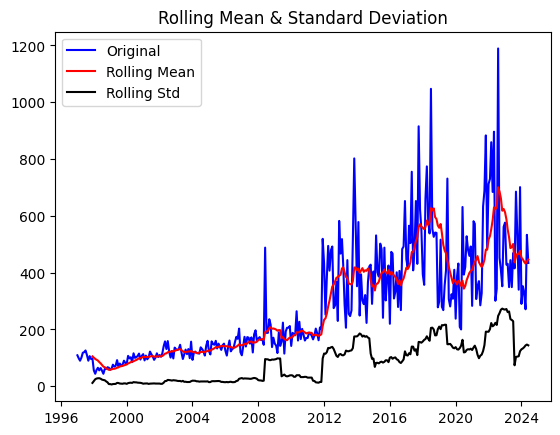

In [8]:
plt.plot(ske_M, color = 'blue', label='Original')
plt.plot(rolmean, color = 'red', label='Rolling Mean')
plt.plot(rolstd, color = 'black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# our mean and std is not constant, hence we conclude that this time series
# is not stationary

In [9]:
# Method 2: ADF Test
from statsmodels.tsa.stattools import adfuller

In [10]:
result = adfuller(ske_M, autolag='AIC')
output = pd.Series(result[0:4], index=['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

# the null hypothsis of the ADF test is that the data is not stationary
# we do not reject the null hypothesis because p-value =0.590 > 0.05
# hence we conclude that the data is not stationary

ADF Statistic                   -1.382216
p-value                          0.590772
#Lags Used                      10.000000
Number of Observations Used    319.000000
Critical Value (1%)             -3.451017
Critical Value (5%)             -2.870643
Critical Value (10%)            -2.571620
dtype: float64


In [11]:
# As we will need to test for stationary in the future, we define a function that can easily help us with this

def test_stationarity(timeseries):

    #rolling statistics
    movingAverage = timeseries.rolling(window=12).mean().dropna()
    movingSTD = timeseries.rolling(window=12).std().dropna()

    #plot rolling statistics
    plt.plot(timeseries, color = 'blue', label='Original')
    plt.plot(movingAverage, color = 'red', label='Rolling Mean')
    plt.plot(movingSTD, color = 'black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #adf test
    result = adfuller(timeseries, autolag='AIC')
    output = pd.Series(result[0:4], index=['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in result[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    

### A time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.

+ **Additive time series:** Trend and  seasonal component is added on behind each other, we can usually tell this from the time series because the amplitude of the seasons is not changing very drastically. 

Value = Base Level + Trend + Seasonality + Error

+ **Multiplicative Time Series:**　The amplitude is a function of time, it is multiplying upon itself.

Value = Base Level x Trend x Seasonality x Error

+ seasonal_decompose breaks down our time series data into trend, season and error component. 


#### We break up the time series into its different components to assess whether the time series is multiplicative or additive. 

+ If the data is multiplicative, we perform a box cox (log) transformation first followed by first order differencing. 

+ If the data is additive, we simply start by performing first order differencing. 

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

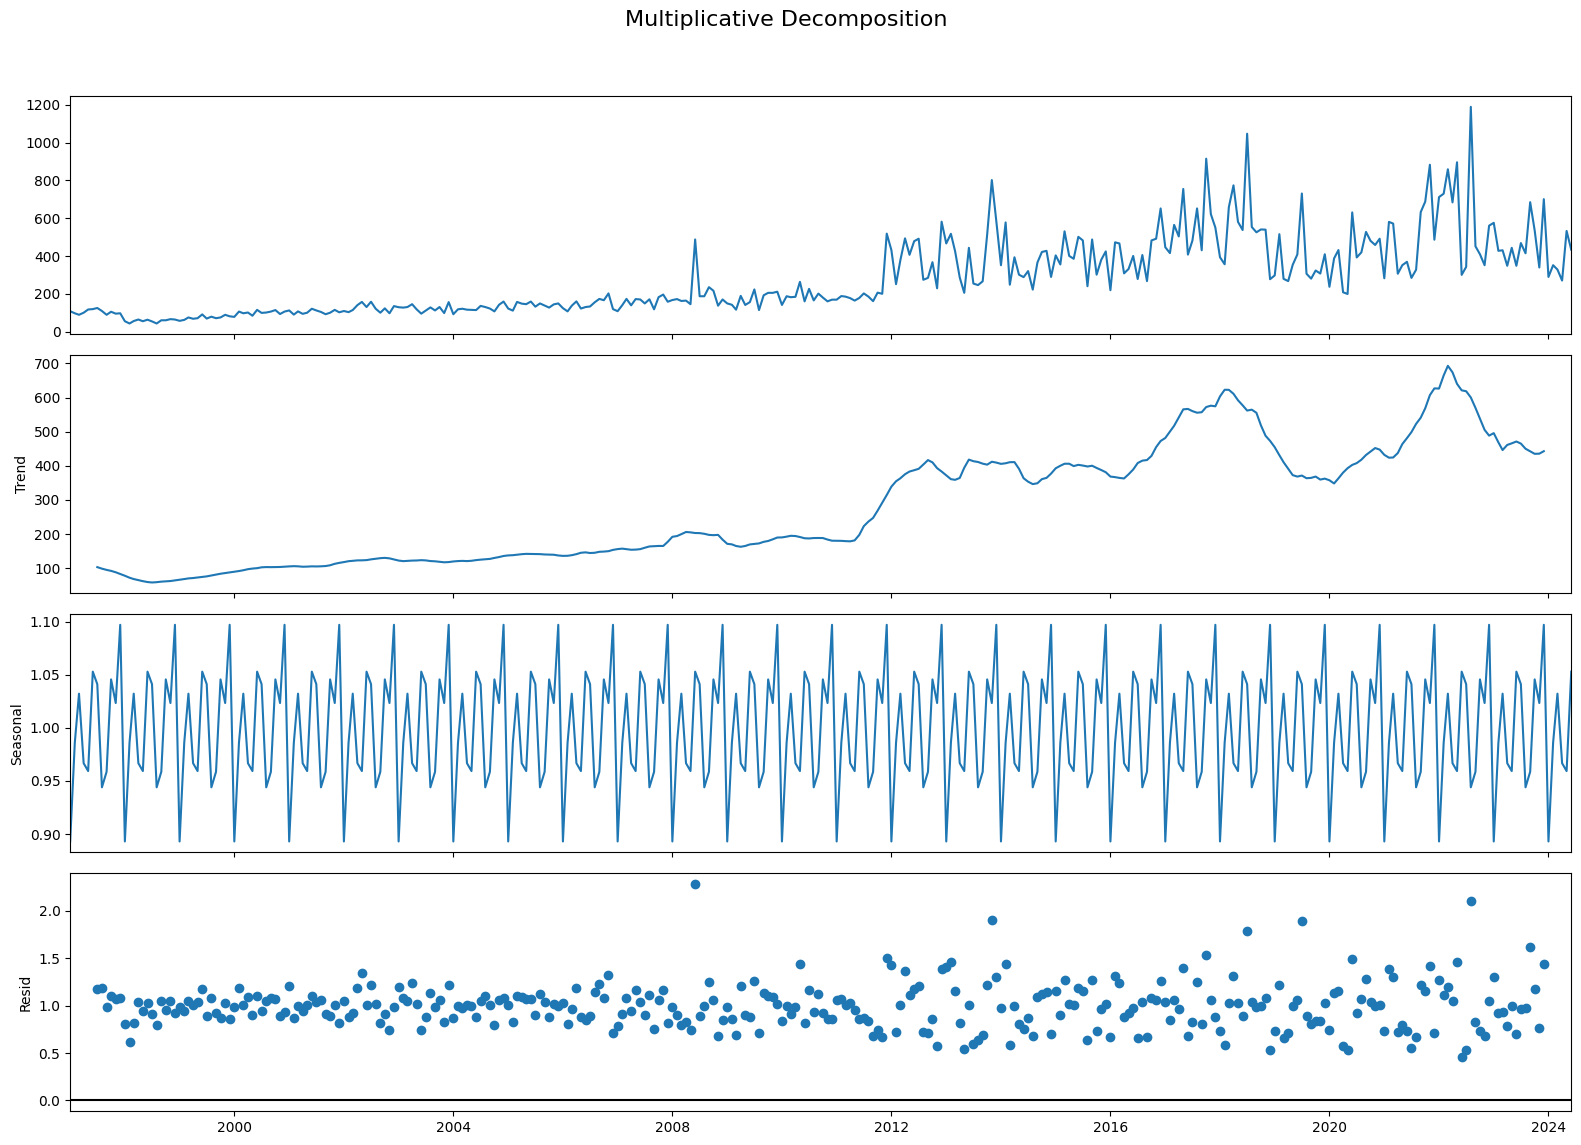

In [13]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(ske_M, model='multiplicative', period=12)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

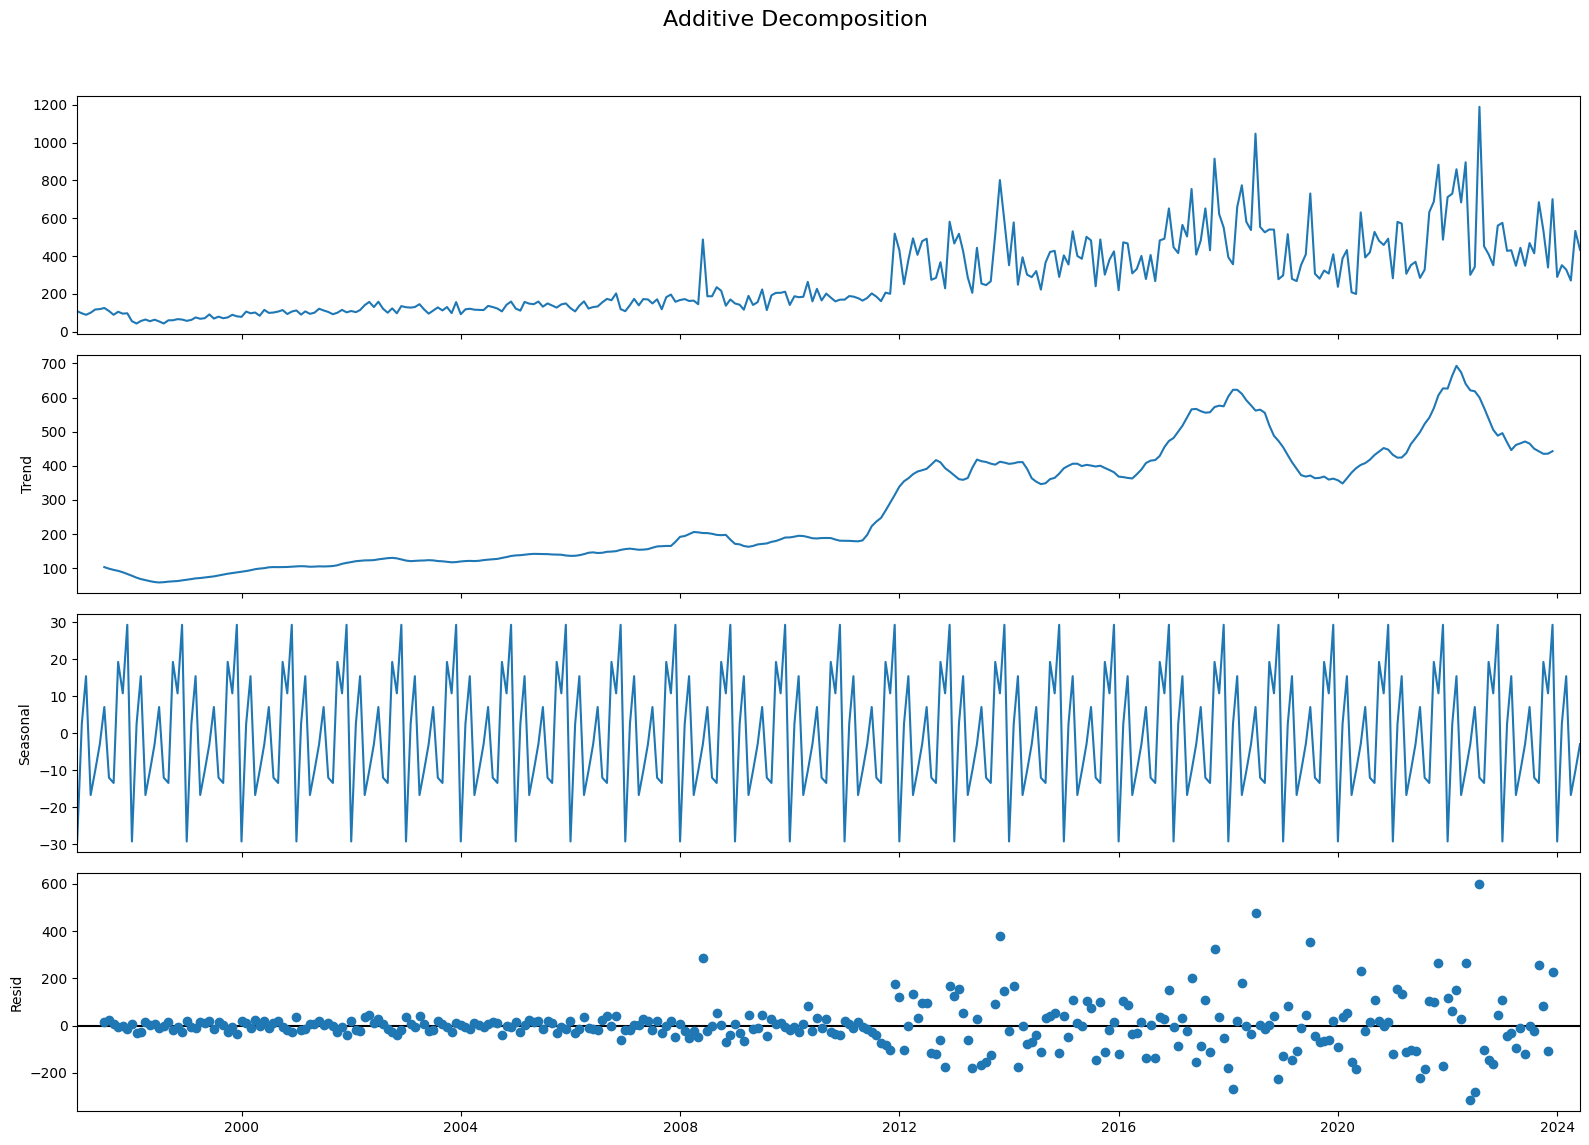

In [14]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(ske_M, model='additive', period=12)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Decomposition analysis

+ The trend component clearly shows the increasing trend in total monthly exports of South Korea as the years goes by. 

+ Isolating the seasonal component, it clearly shows that the time series data is seasonal because of the seasonality patterns in the rise and fall in values each year. 

+ The residuals of the multiplicative decomposiiton shows constant variance from the start date till 2012. From 2012 onwards, the variance of the residuals increases slightly.

+ The residuals of the additive decomposiiton shows low variance from the start date till 2012. From 2012 onwards, the variance of the residuals increases significantly.

+ Multiplicative decomposition should be preferred in this series. 

#### As the time series is multiplicative, we proceed to make the data stationary by doing a box cox transformation first, followed by differencing

In [15]:
from scipy.stats import boxcox

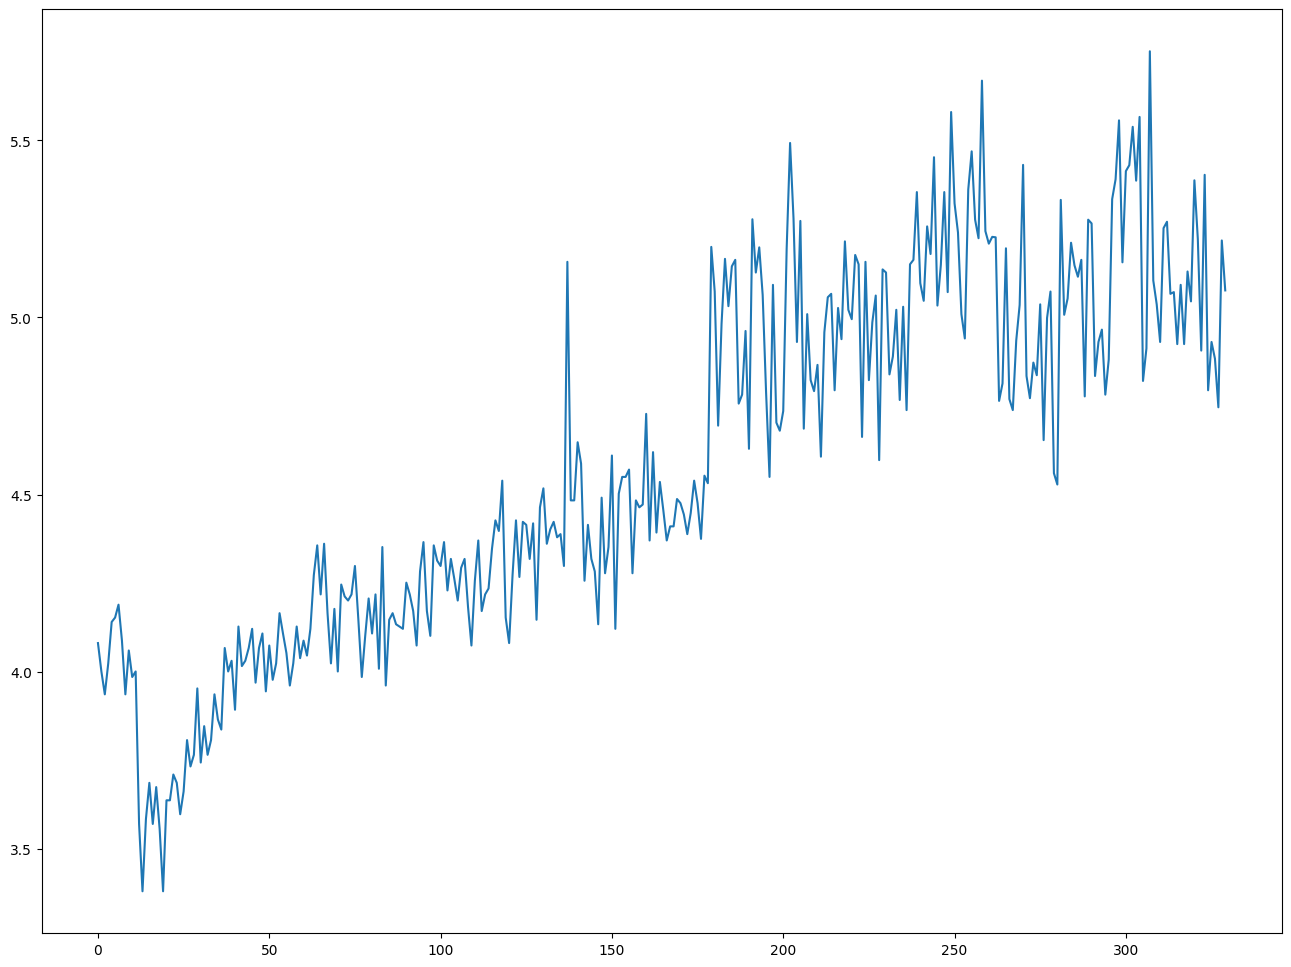

In [16]:
ske_M_boxcox, lam = boxcox(ske_M['Total Exports'])
plt.plot(ske_M_boxcox)

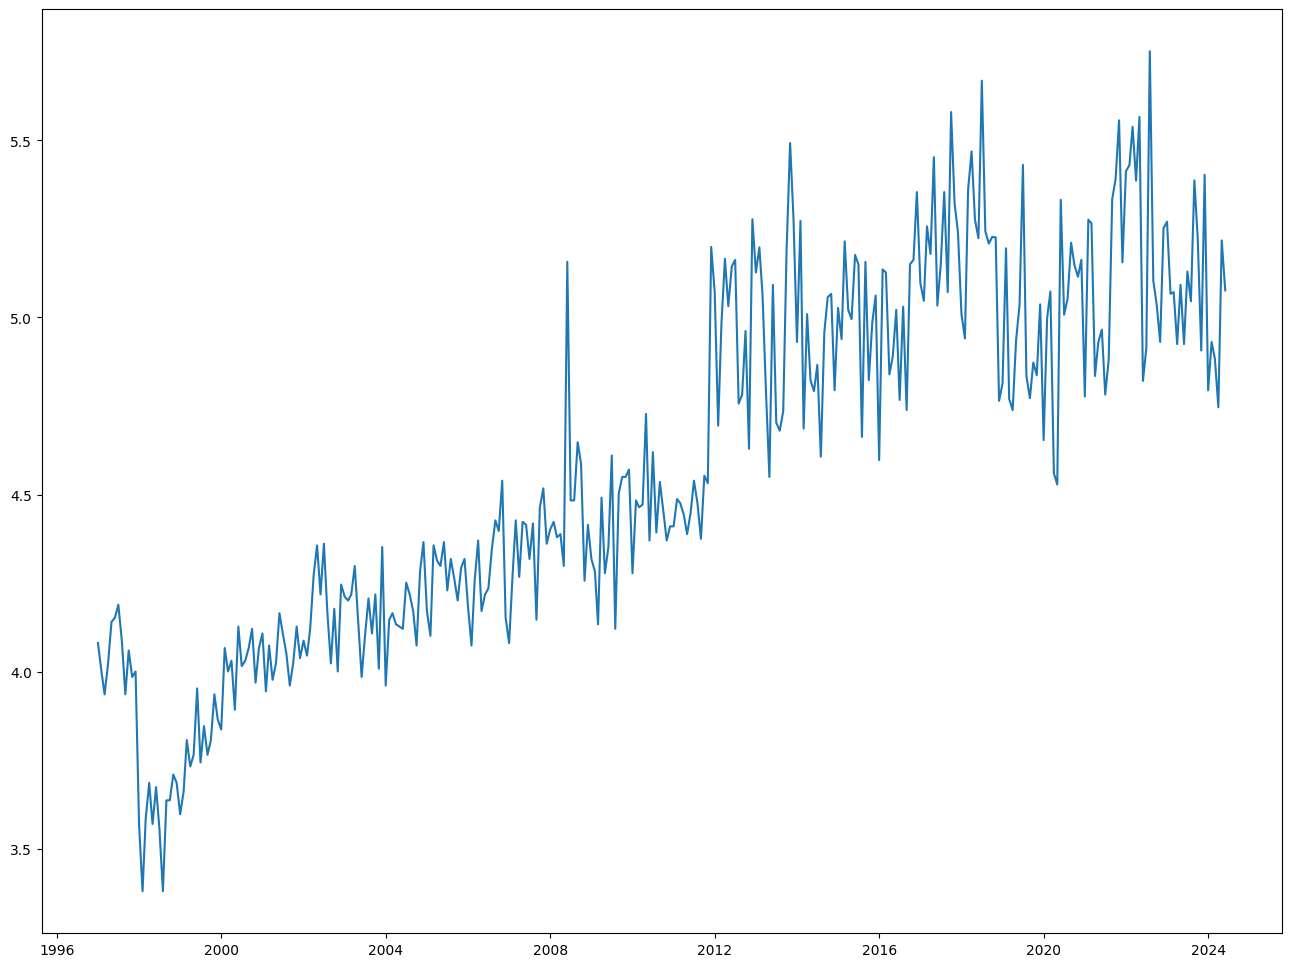

In [17]:
ske_M_boxcox = pd.DataFrame(data = ske_M_boxcox, index=ske_M.index)
ske_M_boxcox.columns = ['Total Exports']
plt.plot(ske_M_boxcox)

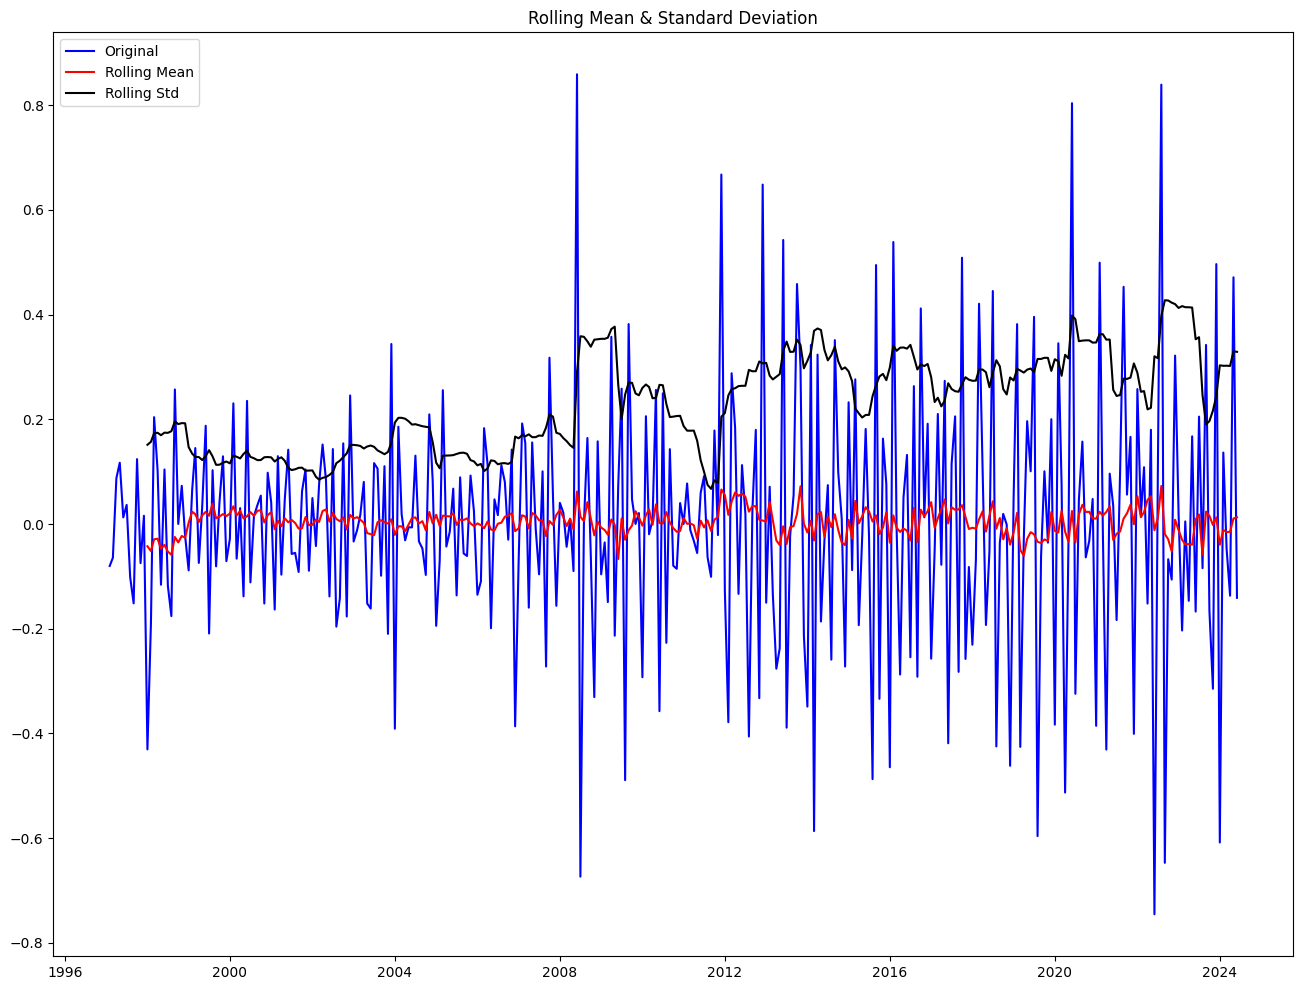

ADF Statistic                 -8.206324e+00
p-value                        7.008860e-13
#Lags Used                     1.000000e+01
Number of Observations Used    3.180000e+02
Critical Value (1%)           -3.451082e+00
Critical Value (5%)           -2.870672e+00
Critical Value (10%)          -2.571636e+00
dtype: float64


In [18]:
ske_M_boxcoxD = ske_M_boxcox.diff().dropna()
test_stationarity(ske_M_boxcoxD)

+ We reject the null hypothsis and conclude that the timeseries after performing boxcox transformation and differencing is stationary.

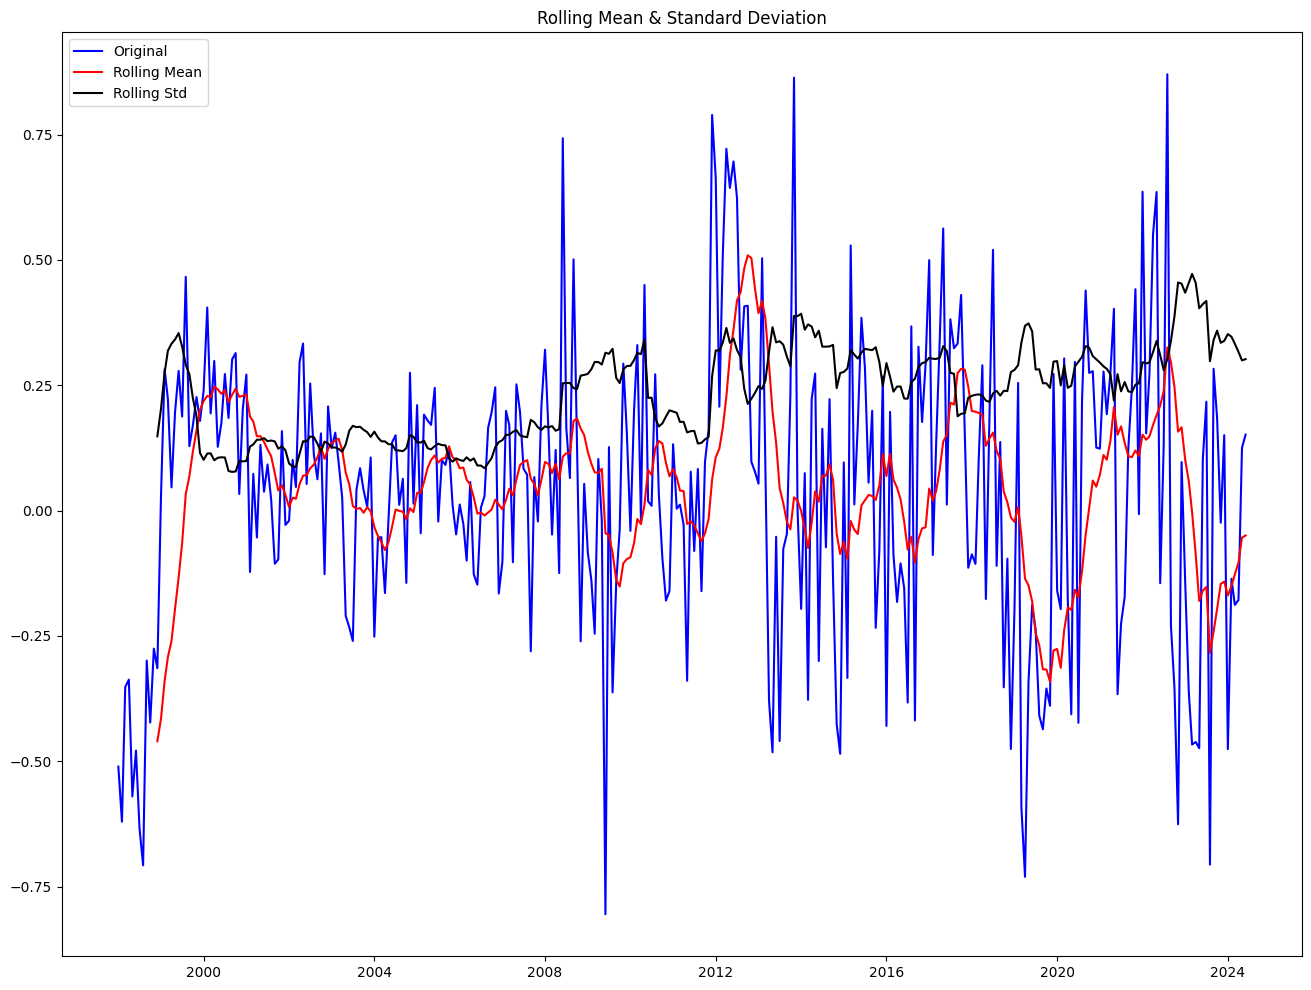

ADF Statistic                 -6.862779e+00
p-value                        1.586829e-09
#Lags Used                     1.100000e+01
Number of Observations Used    3.060000e+02
Critical Value (1%)           -3.451902e+00
Critical Value (5%)           -2.871032e+00
Critical Value (10%)          -2.571827e+00
dtype: float64


In [19]:
# seasonal differencing: we perform seasonal differencing by differencing our time series by periods of 12
ske_M_boxcoxSD = ske_M_boxcox.diff(periods=12).dropna()
test_stationarity(ske_M_boxcoxSD)

+ We reject the null hypothsis and conclude that the timeseries after performing boxcox and seasonal differencing is stationary.

### ACF and PACF

We plot out the ACF and PACF graph of the stationary model to find out the order we should use for the AR and MA component of the SARIMA model

+ Identification of an AR model is done using the PACF plot.

We identify the AR model by when the PACF "shuts off" past the order of the model. It means that the PACF are equal to 0 beyond a certain point. The number before the non-zero/statistically insignificant partial autocorrelations gives the order of the AR model. 

+ Identification of an MA model is done using the ACF plot.

We identify the MA model by how it tapers towards 0 in some manner. For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. The ACF will have non-zero autocorrelations only at lags involved in the model.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

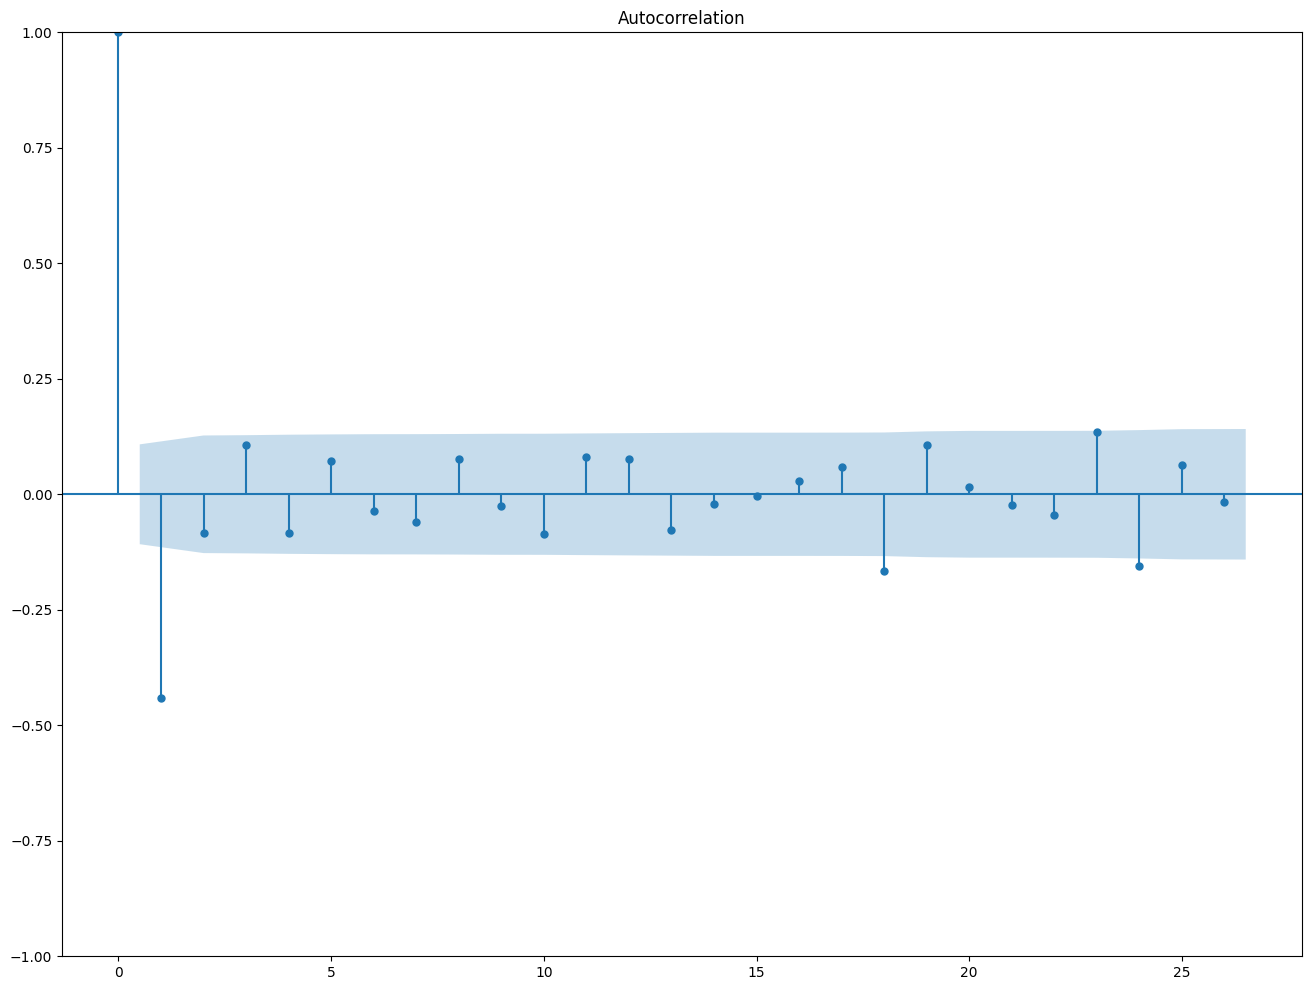

In [21]:
plot_acf(ske_M_boxcoxD)
plt.show()

Based on ACF, we should have a MA order of 1 month

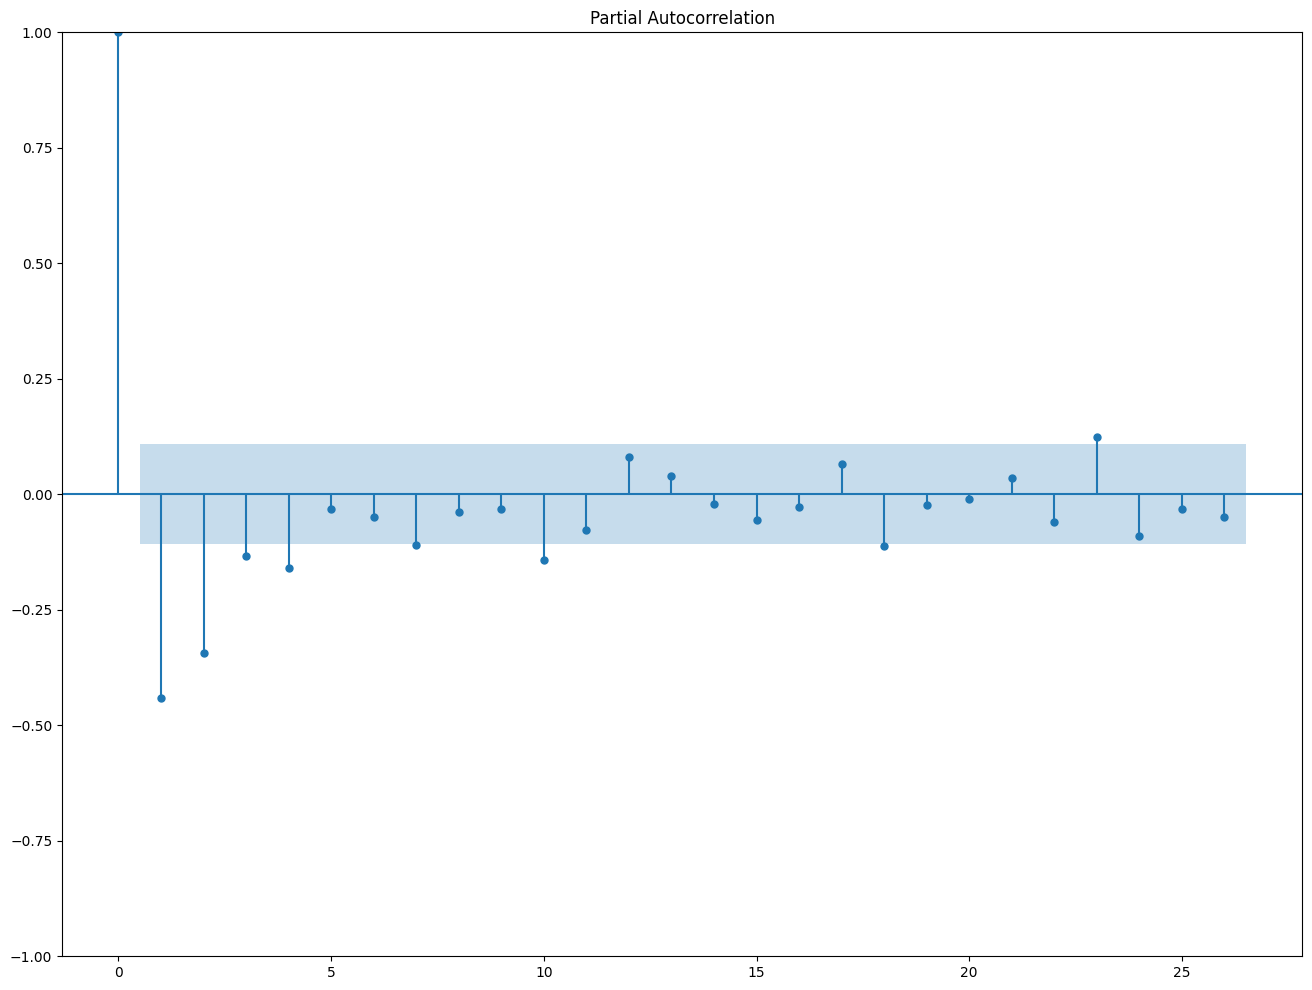

In [22]:
plot_pacf(ske_M_boxcoxD)
plt.show()

Based on PACF, we should have a AR order of 2 months

** Therefore we have p=2, d=1, q=1

### Forecasting 

Predict the monthly total export for the next 36 months. We will use the ARIMA and SARIMA method to forecast the monthly total exports, which allows us to forecast future values in terms of a linear combination of past values. 

We first split the log transformed data into training set and test set, with the test set consisting of 36 months. We conducted first order difference later using the ARIMA model.

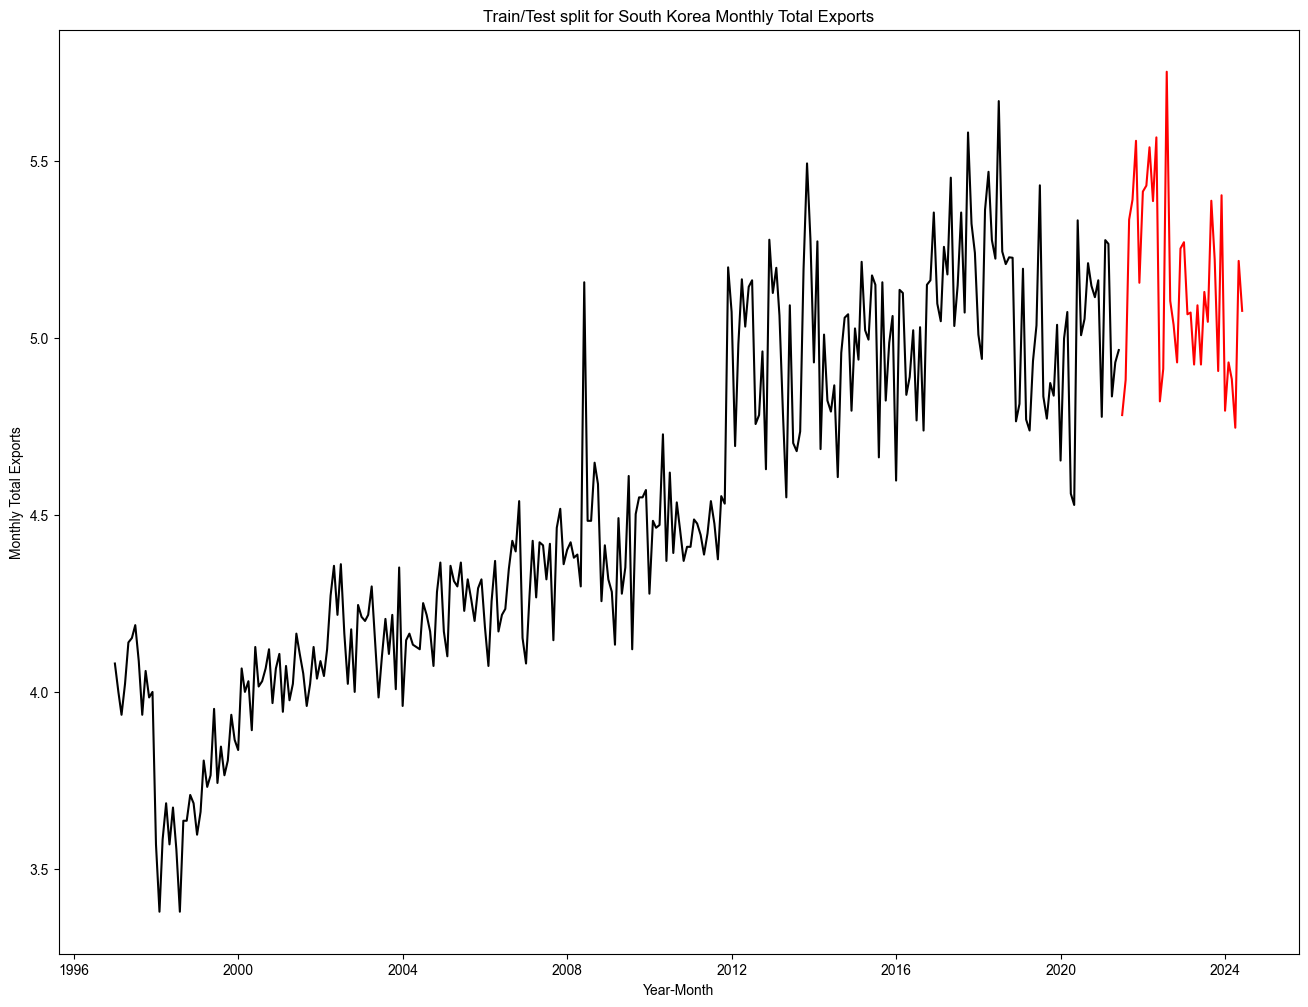

In [23]:
train = ske_M_boxcox[:-36]
test = ske_M_boxcox[-36:]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for South Korea Monthly Total Exports")
plt.ylabel("Monthly Total Exports")
plt.xlabel('Year-Month')
sns.set()
plt.show()

The black line corresponds to our training data and the red line corresponds to our test data.

### Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

The SARIMA model is designed to handle data with seasonal patterns. 

The method integrates the principles of Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

The SARIMA approach is optimal for single-variable time series that exhibit a trend and seasonal variations.

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
sarima_model_fit = ARIMA(train, order = (2,1,1), seasonal_order = (0,1,0,12)).fit()
sarima_model_fit.fittedvalues
# predicted values for the ske_M_boxcox timeseries

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Date
1997-01-01    0.000000
1997-02-01    4.080513
1997-03-01    4.000317
1997-04-01    3.935745
1997-05-01    4.023101
                ...   
2021-02-01    5.181292
2021-03-01    5.272589
2021-04-01    4.761311
2021-05-01    4.753538
2021-06-01    5.609863
Length: 294, dtype: float64

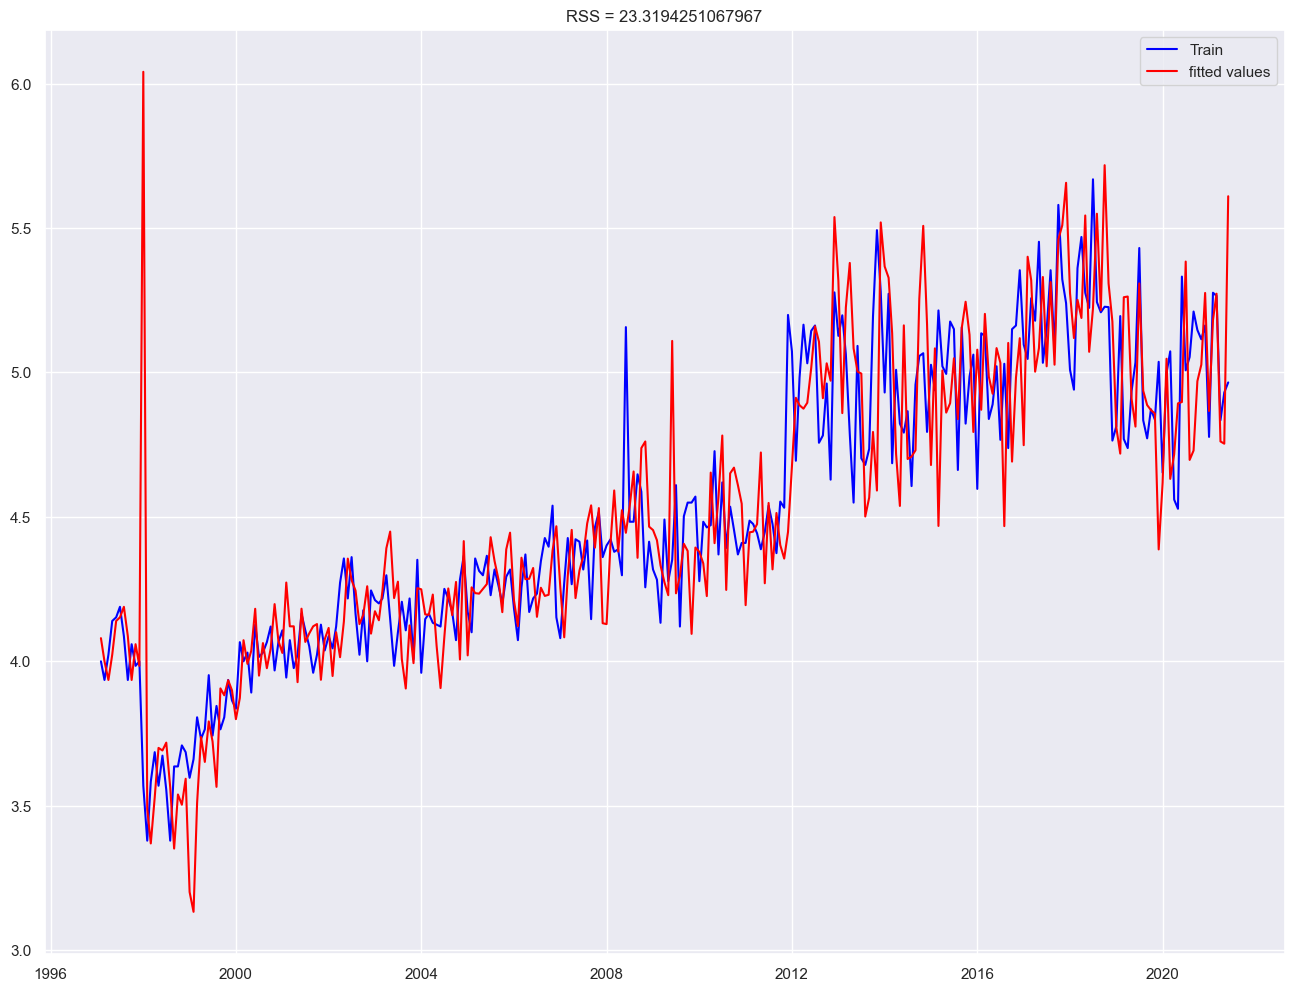

In [26]:
fitted_values = pd.DataFrame(sarima_model_fit.fittedvalues, columns = ['Predicted Total Monthly Exports'])
fitted_values = fitted_values.iloc[1:] # as there is no predicted value for 1997-01-01
train211 = train.iloc[1:] # to start from 1997-02-01

def fittedplot(train_data, fit_data):
    RSS = sum((train_data['Total Exports'] - fit_data['Predicted Total Monthly Exports'])**2)
    # calculating sum of squares residual
    plt.plot(train_data, color = 'blue', label = 'Train')
    plt.plot(fit_data, color = 'red', label = 'fitted values')
    plt.title(f"RSS = {RSS}")
    plt.legend(loc='best')
    plt.show()

fittedplot(train211, fitted_values)

                0
count  294.000000
mean     0.010612
std      0.369193
min     -2.470792
25%     -0.144511
50%      0.002644
75%      0.154489
max      4.080513


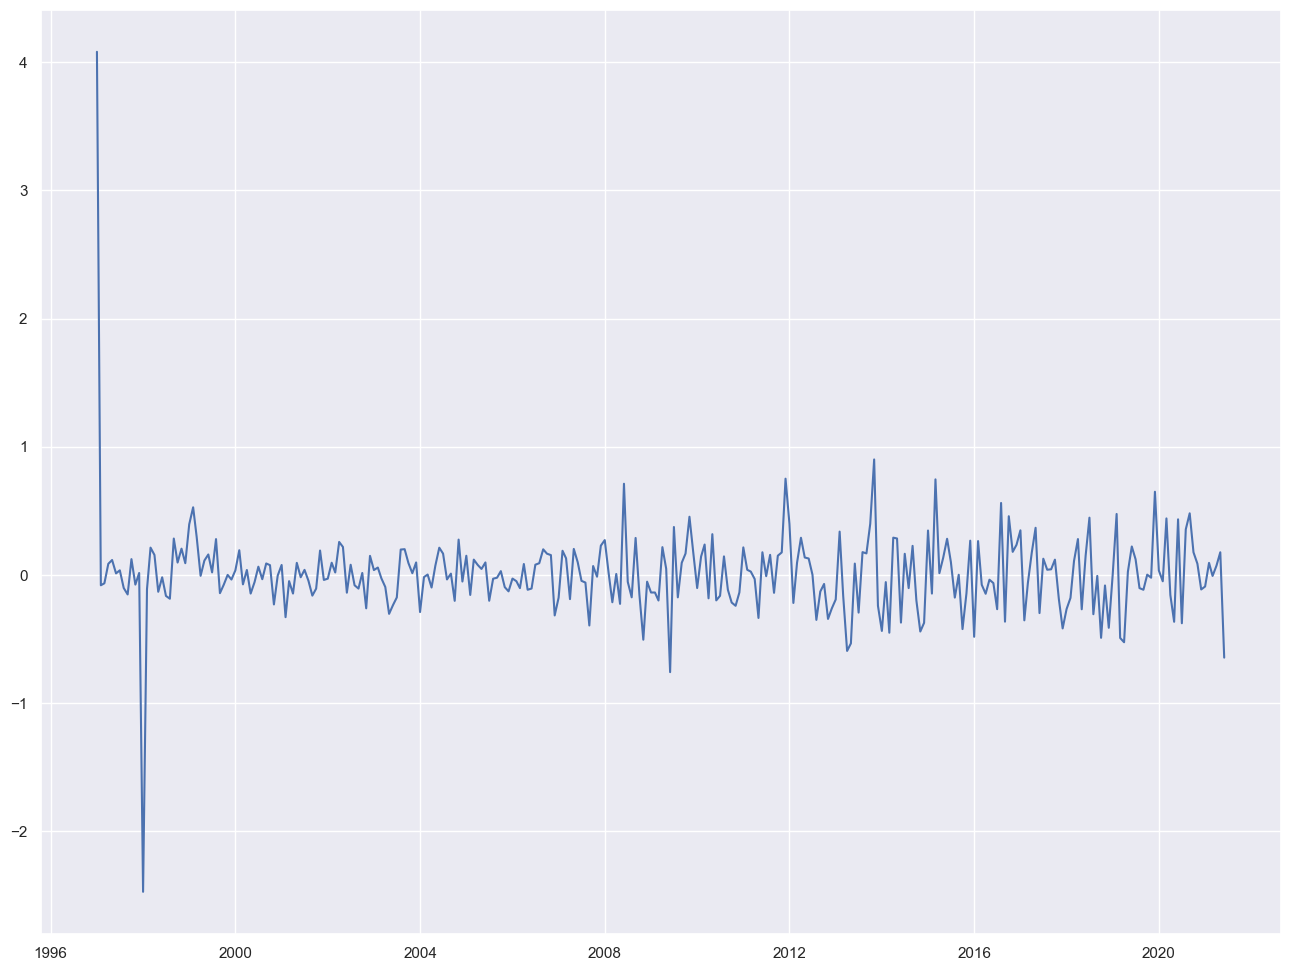

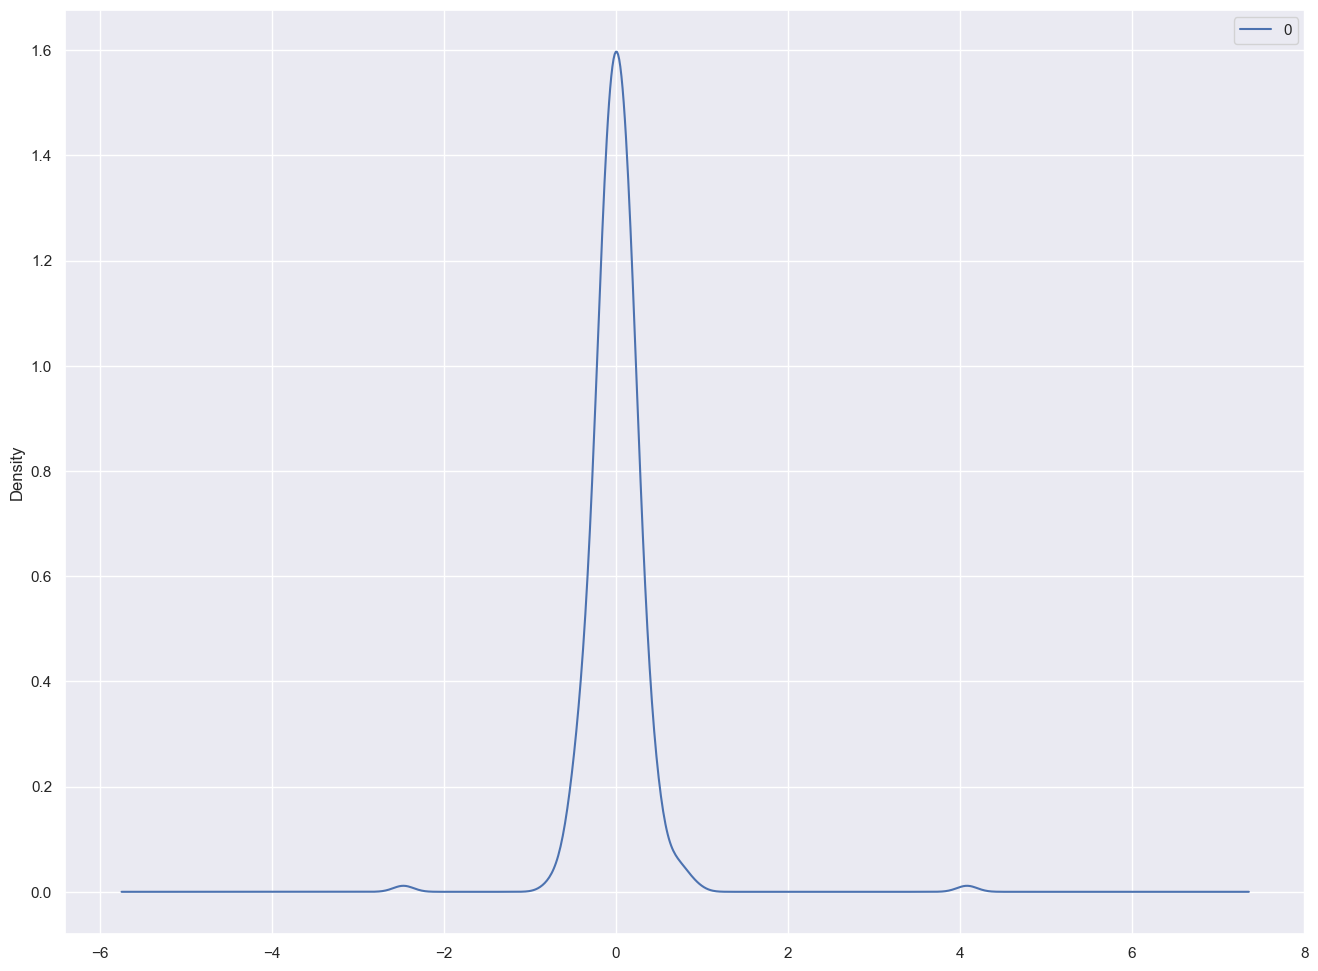

In [27]:
def residualanalysis(model_fit):
    fitted_values_resid = pd.DataFrame(model_fit.resid)
    plt.plot(fitted_values_resid)
    # density plot of residuals
    fitted_values_resid.plot(kind='kde')
    plt.plot()
    # summary stats of residuals
    print(fitted_values_resid.describe())

residualanalysis(sarima_model_fit)

,residuals
count,36.000000
mean,-0.040566
std,0.302139
min,-0.564157
25%,-0.254255
50%,-0.089647
75%,0.095995
max,0.575405


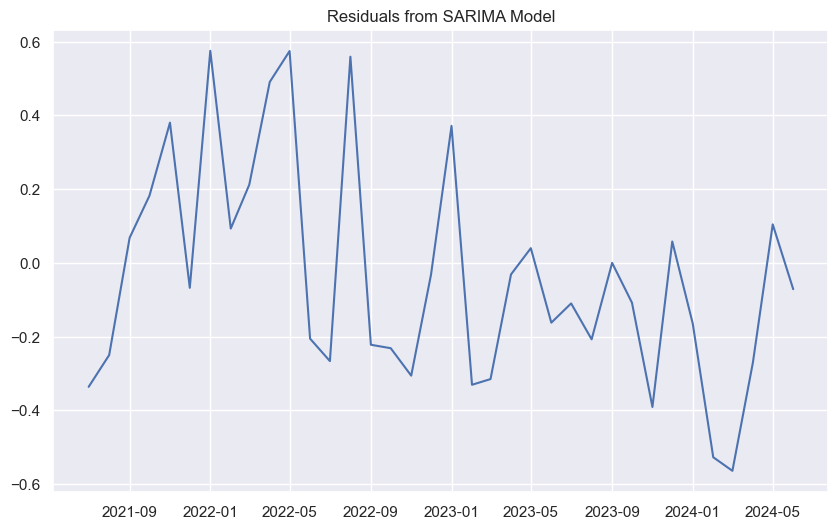

In [28]:
predictions = sarima_model_fit.forecast(len(test))
predictions = pd.DataFrame(predictions, index=test.index)
predictions.columns = ['Predicted Exports']
residuals = pd.DataFrame(test['Total Exports'] - predictions['Predicted Exports'])
residuals.columns = ["residuals"]
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model')
residuals.describe()

Our residuals shows constant mean and variance over the test period, indicating that we have captured most of the trends and seasonality of the time series 

In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

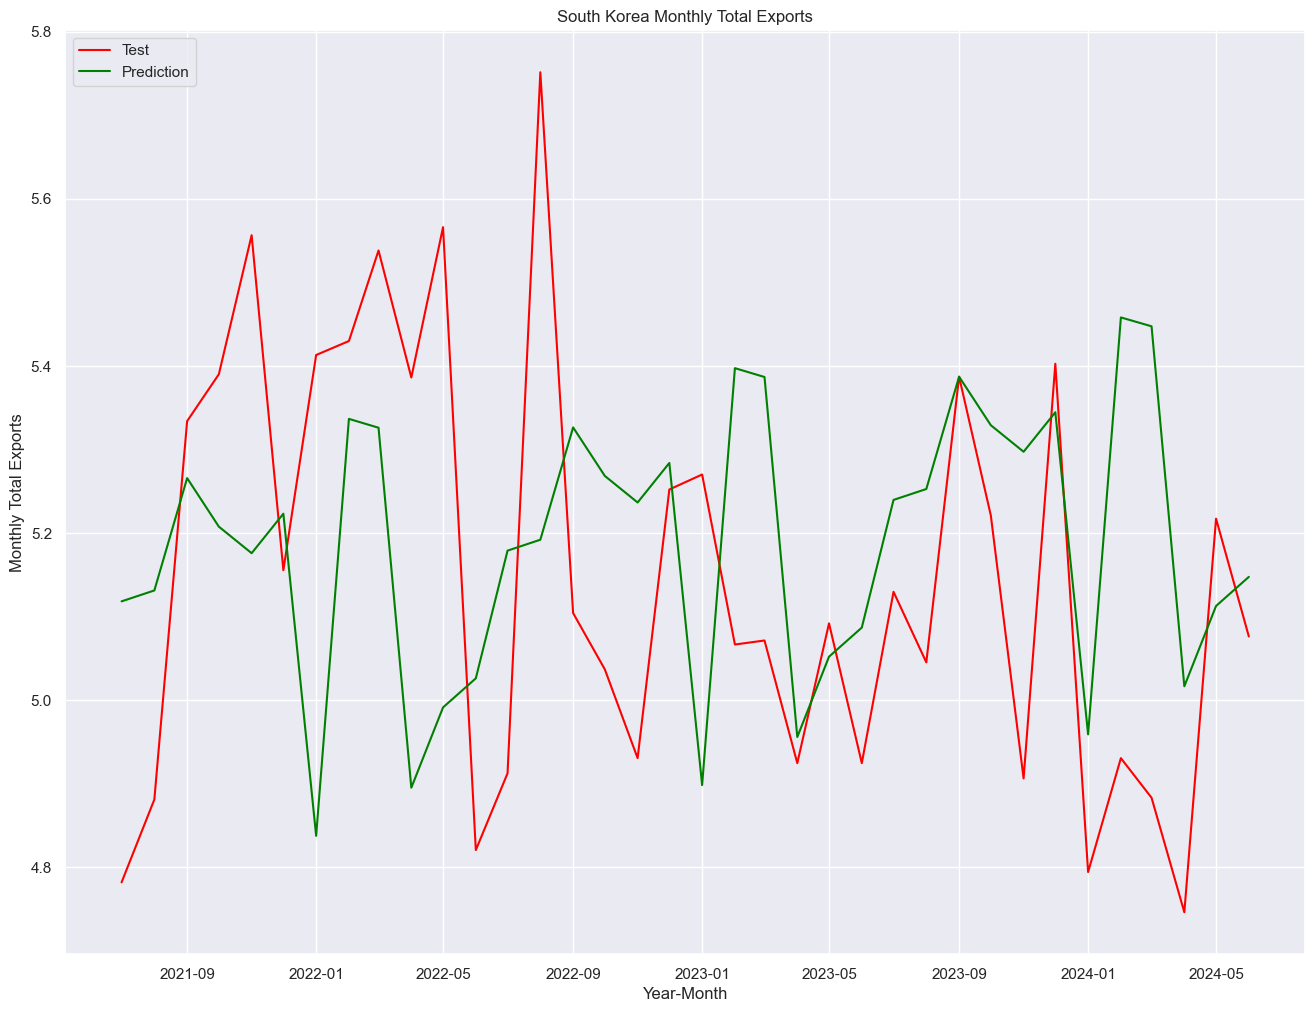

Mean Absolute Error: 0.24673541299770896
Mean Absolute Percent Error: 0.0479
Root Mean Squared Error: 0.30066259708282295


In [30]:
def testVpred(test_data, pred_data):

    plt.plot(test_data, label = "Test", color = "red")
    plt.plot(pred_data, label = "Prediction", color = "green")
    plt.title("South Korea Monthly Total Exports")
    plt.ylabel("Monthly Total Exports")
    plt.xlabel('Year-Month')
    plt.legend(loc = "upper left")
    sns.set()
    plt.show()
    
    print(f"Mean Absolute Error: {mean_absolute_error(test_data, pred_data)}")
    residuals = pd.DataFrame(test_data['Total Exports'] - pred_data['Predicted Exports'])
    residuals.columns = ["residuals"]
    resditest = residuals["residuals"] / test["Total Exports"]
    print(f"Mean Absolute Percent Error: {round(np.mean(abs(resditest)),4)}")
    print(f"Root Mean Squared Error: {sqrt(mean_squared_error(test_data, pred_data))}")

testVpred(test, predictions)

We observe that our predictions tends to have constant mean and variance over time however it doesn't predict as accurately as it can.

Because we are forecasting 36 months of total monthly exports, we do not need to do it immediately for the entire 36 months. We can predict the first month only, update our model, and then predict the subsequent month. 

#### This is called the rolling forecast origin.

Idea: Predict one month in advance each time
+ Train on months 1,2,3,... k-3 -> predict month k-2

+ Train on months 1,2,3,... k-3, k-2 -> predict month k-1

+ Train on months 1,2,3,... k-3, k-2, k-1 -> predict month k

In [31]:
import datetime

In [32]:
predictions_rolling = pd.Series()
for end_date in test.index:
    train_rolling = ske_M_boxcox[:end_date - datetime.timedelta(days=1)]
    sarima_model_fit = ARIMA(train_rolling, order= (2, 1, 1), seasonal_order= (0, 1, 0, 12)).fit()
    pred = sarima_model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

,residuals
count,36.000000
mean,-0.004120
std,0.373506
min,-0.725918
25%,-0.199558
50%,-0.011297
75%,0.288466
max,0.653590


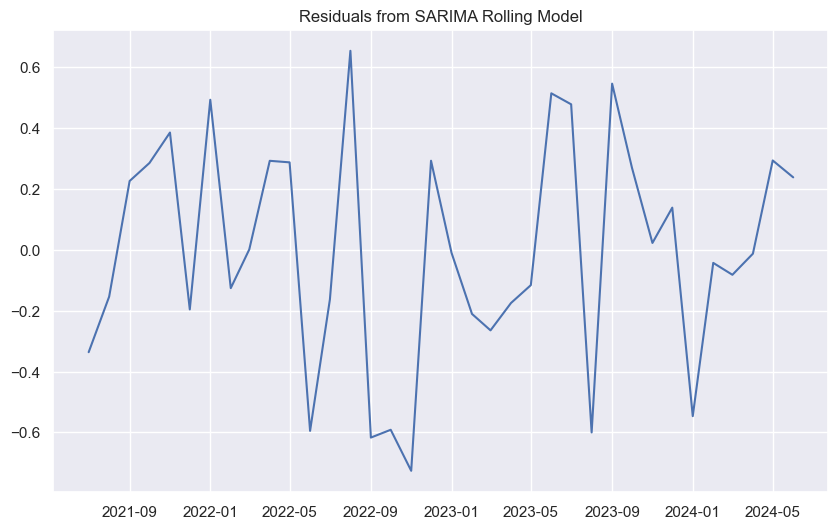

In [33]:
predictions_rolling = pd.DataFrame(predictions_rolling, index=test.index)
predictions_rolling.columns = ['Predicted Exports']
residuals = pd.DataFrame(test['Total Exports'] - predictions_rolling['Predicted Exports'])
residuals.columns = ["residuals"]
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from SARIMA Rolling Model')
residuals.describe()

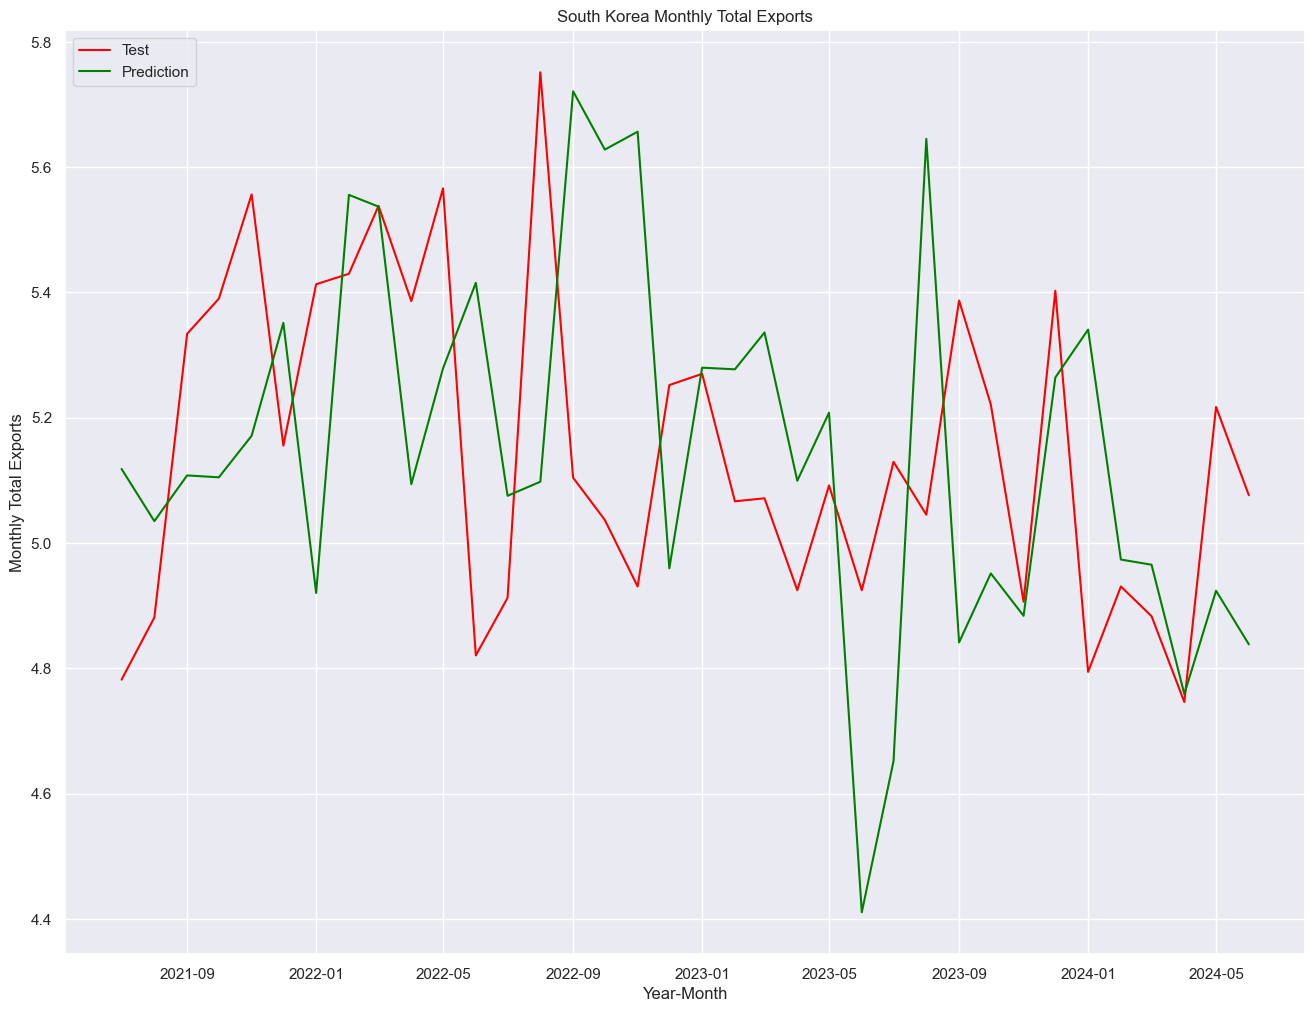

Mean Absolute Error: 0.3049676588280895
Mean Absolute Percent Error: 0.0593
Root Mean Squared Error: 0.36830465978308097


In [34]:
testVpred(test, predictions_rolling)

### AUTO ARIMA

How does auto arima define the optimal combination of order is by two factors using AIC:

+ Goodness of fit, how well are we minimising the residuals.
+ Complexity of the mode. The simplier the model is, the better. 

In [35]:
from pmdarima.arima import auto_arima

In [36]:
auto_arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=True, error_action='warn',trace = True, supress_warnings=True, stepwise = True, random_state=20, n_fits = 50)   

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=129.669, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=10.395, Time=5.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=10.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=52.568, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-30.291, Time=7.07 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-41.645, Time=10.50 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-55.521, Time=20.29 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-58.601, Time=68.34 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-77.112, Time=299.94 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=-79.111, Time=71.68 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=22.98 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=-77.483, Time=67.42 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=6.37 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=-75.526, Time=16.76 sec
 ARIMA(0,1,0)(4,1,1)[12]             

In [37]:
AA_model_fit = ARIMA(train, order = (1,1,0), seasonal_order=(4,1,1, 12)).fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
AA_model_fit.fittedvalues

Date
1997-01-01    0.000000
1997-02-01    4.080513
1997-03-01    4.000318
1997-04-01    3.935745
1997-05-01    4.023101
                ...   
2021-02-01    4.941620
2021-03-01    5.186250
2021-04-01    5.220925
2021-05-01    4.903232
2021-06-01    5.063075
Length: 294, dtype: float64

In [39]:
AAfitted_values = pd.DataFrame(AA_model_fit.fittedvalues, columns = ['Predicted Total Monthly Exports'])
AAfitted_values = AAfitted_values.iloc[1:] # as there is no predicted value for 1997-01-01
AAtrain = train.iloc[1:] # to start from 1997-02-01
AAtrain

,Total Exports
Date,
1997-02-01,4.000317
1997-03-01,3.935745
1997-04-01,4.023101
1997-05-01,4.139984
1997-06-01,4.152546
...,...
2021-02-01,5.275964
2021-03-01,5.265365
2021-04-01,4.834570


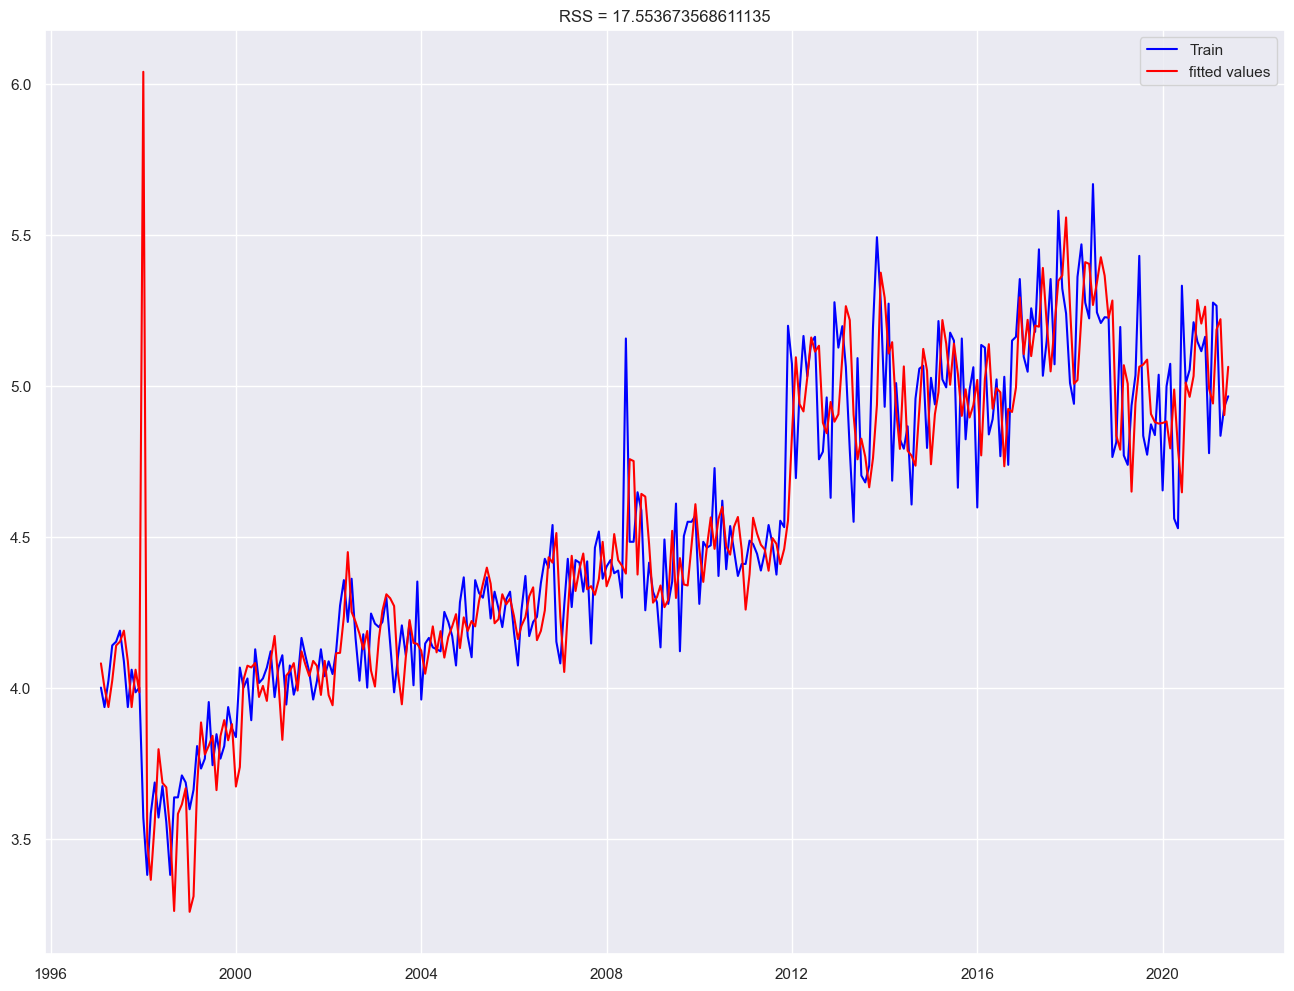

In [40]:
fittedplot(AAtrain, AAfitted_values)

                0
count  294.000000
mean     0.011681
std      0.341469
min     -2.470792
25%     -0.118805
50%      0.005277
75%      0.130897
max      4.080513


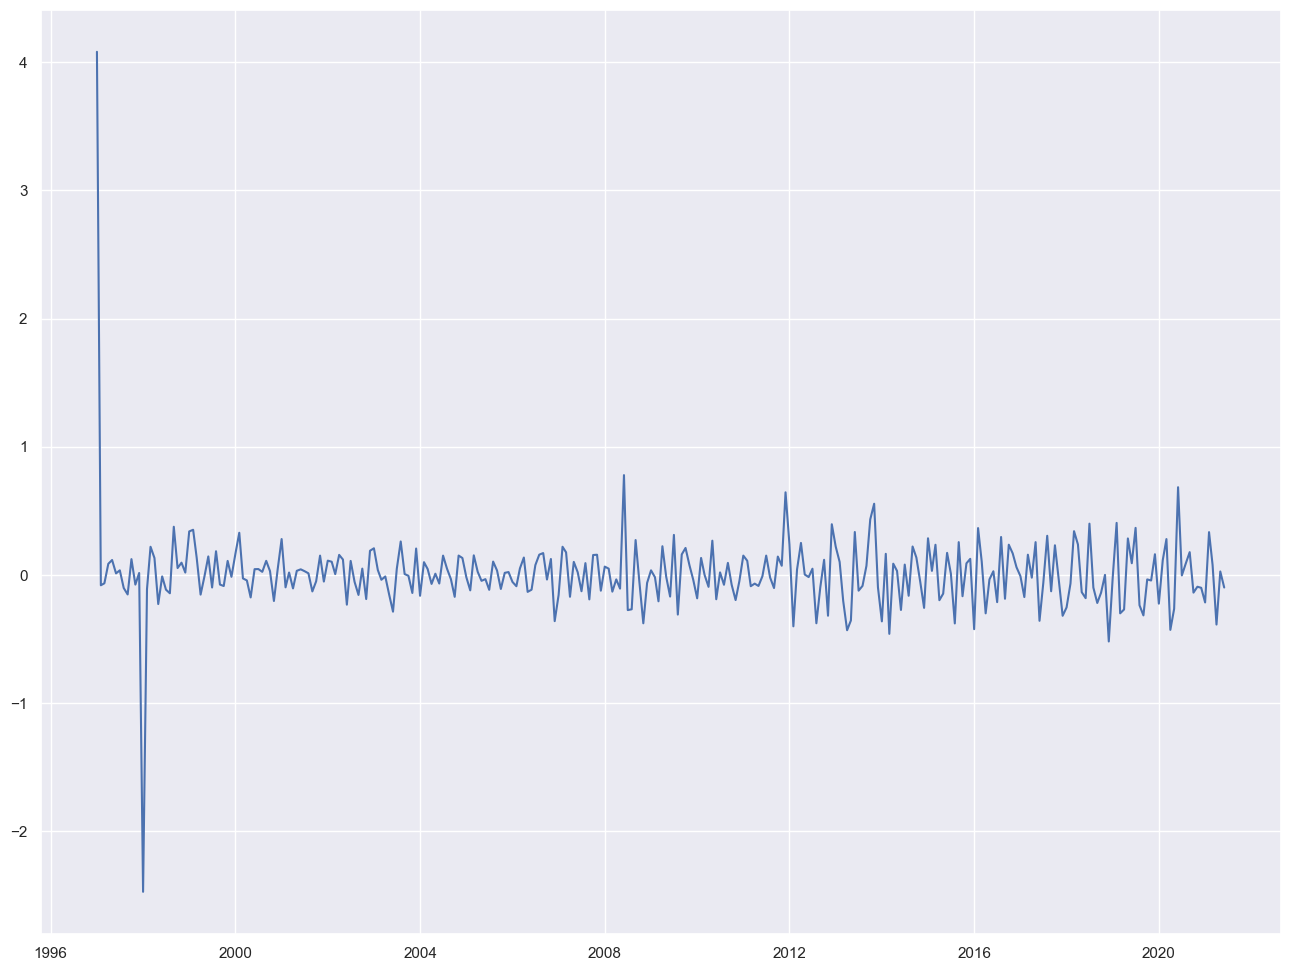

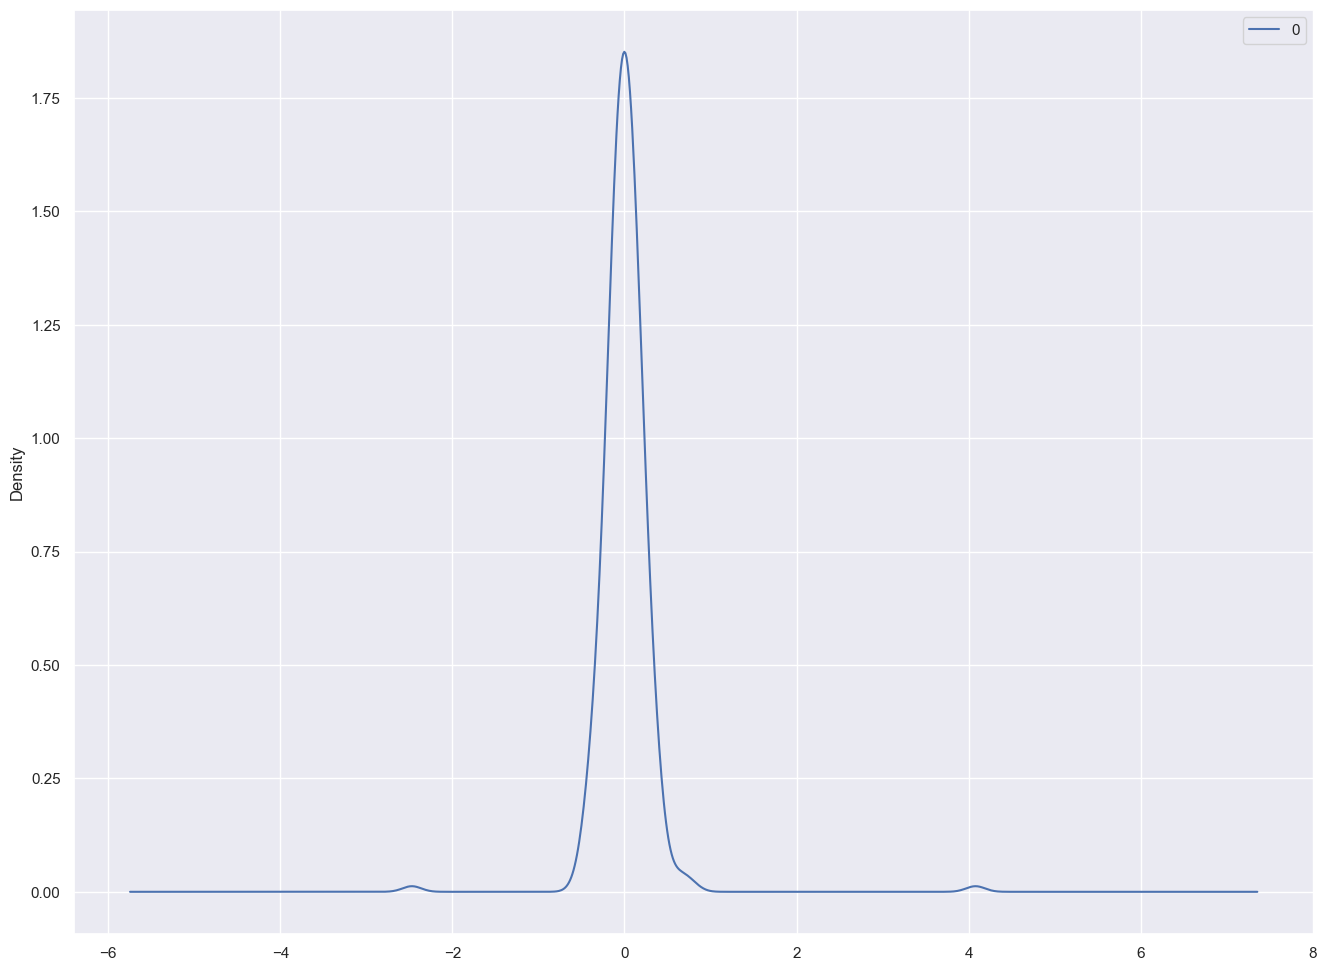

In [41]:
residualanalysis(AA_model_fit)

,residuals
count,36.000000
mean,-0.004120
std,0.373506
min,-0.725918
25%,-0.199558
50%,-0.011297
75%,0.288466
max,0.653590


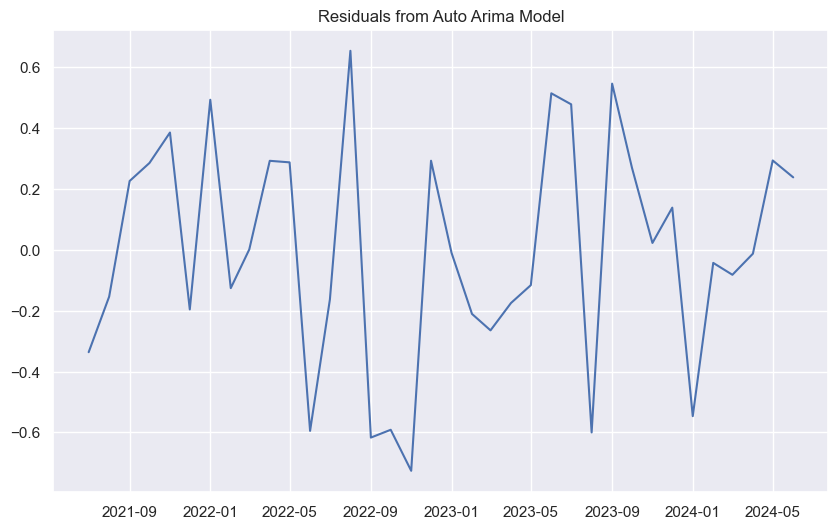

In [42]:
AApredictions = AA_model_fit.forecast(len(test))
AApredictions = pd.DataFrame(AApredictions, index=test.index)
AApredictions.columns = ['Predicted Exports']
AAresiduals = pd.DataFrame(test['Total Exports'] - AApredictions['Predicted Exports'])
AAresiduals.columns = ["residuals"]
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from Auto Arima Model')
residuals.describe()

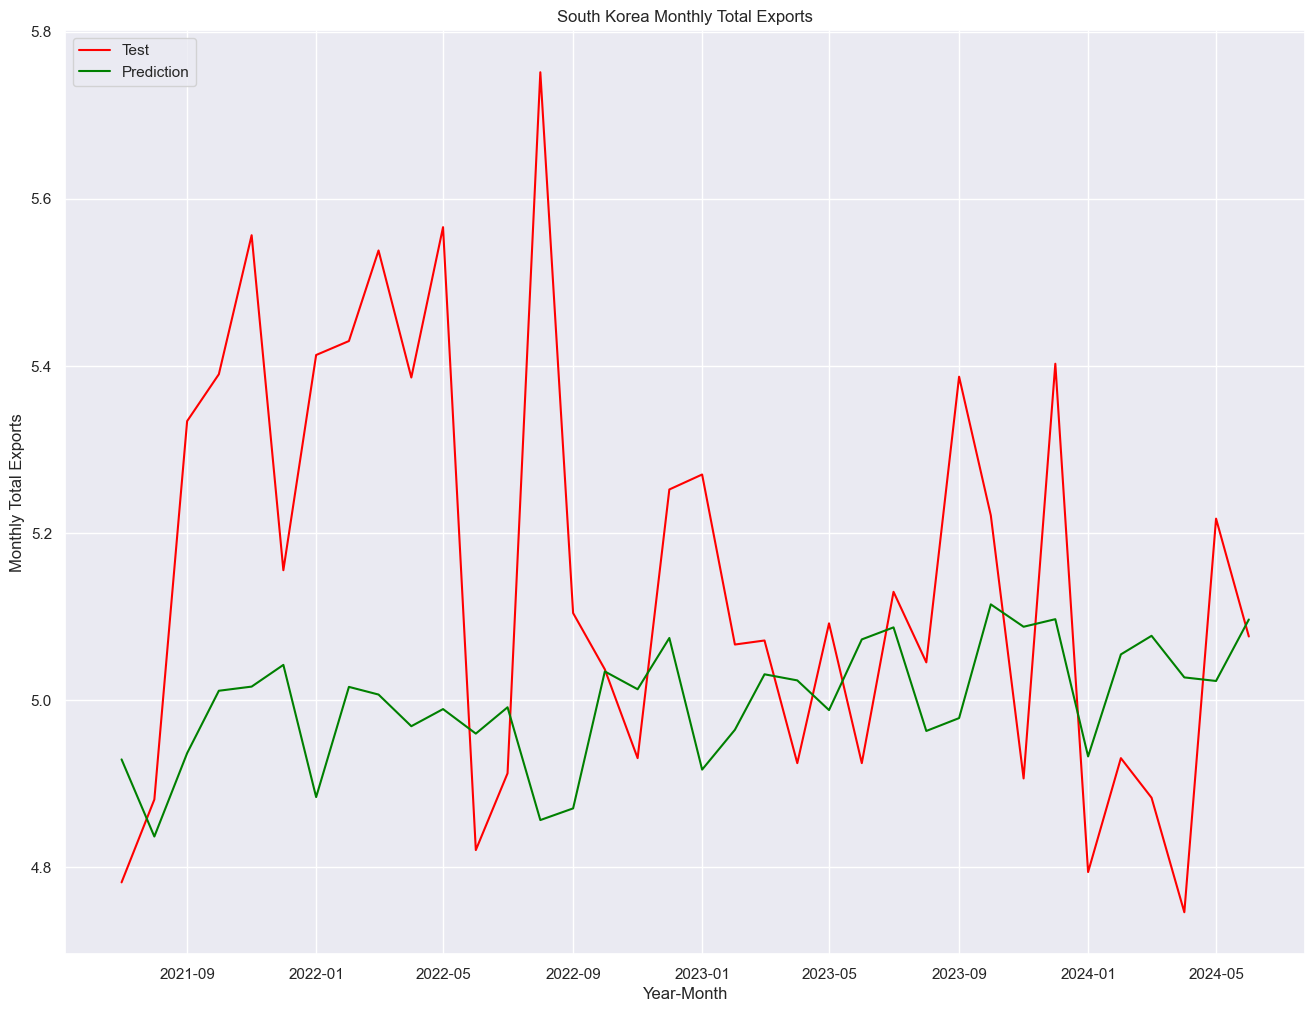

Mean Absolute Error: 0.23956606130940392
Mean Absolute Percent Error: 0.0452
Root Mean Squared Error: 0.31051623187842425


In [43]:
testVpred(test, AApredictions)

### We attempt to achieve better predictions with lesser errors using the rolling forecast origin method

In [45]:
AApredictions_rolling = pd.Series()
for end_date in test.index:
    AAtrain_rolling = ske_M_boxcox[:end_date - datetime.timedelta(days=1)]
    AA_model_fit = ARIMA(AAtrain_rolling, order = (1,1,0), seasonal_order=(4,1,1, 12)).fit()
    AApred = AA_model_fit.predict(end_date)
    AApredictions_rolling.loc[end_date] = AApred.loc[end_date]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

,residuals
count,36.000000
mean,-0.000683
std,0.308678
min,-0.624130
25%,-0.171320
50%,-0.040299
75%,0.137862
max,0.976943


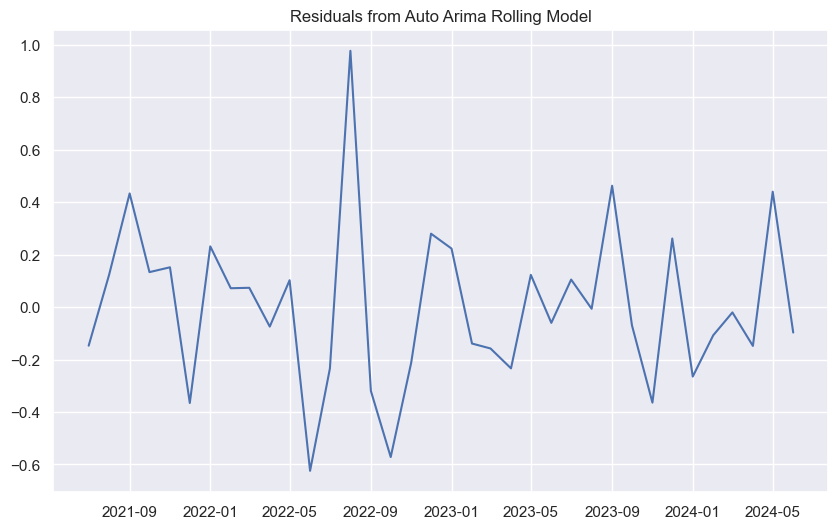

In [46]:
AApredictions_rolling = pd.DataFrame(AApredictions_rolling, index=test.index)
AApredictions_rolling.columns = ['Predicted Exports']
AAresiduals = pd.DataFrame(test['Total Exports'] - AApredictions_rolling['Predicted Exports'])
AAresiduals.columns = ["residuals"]
plt.figure(figsize=(10,6))
plt.plot(AAresiduals)
plt.title('Residuals from Auto Arima Rolling Model')
AAresiduals.describe()

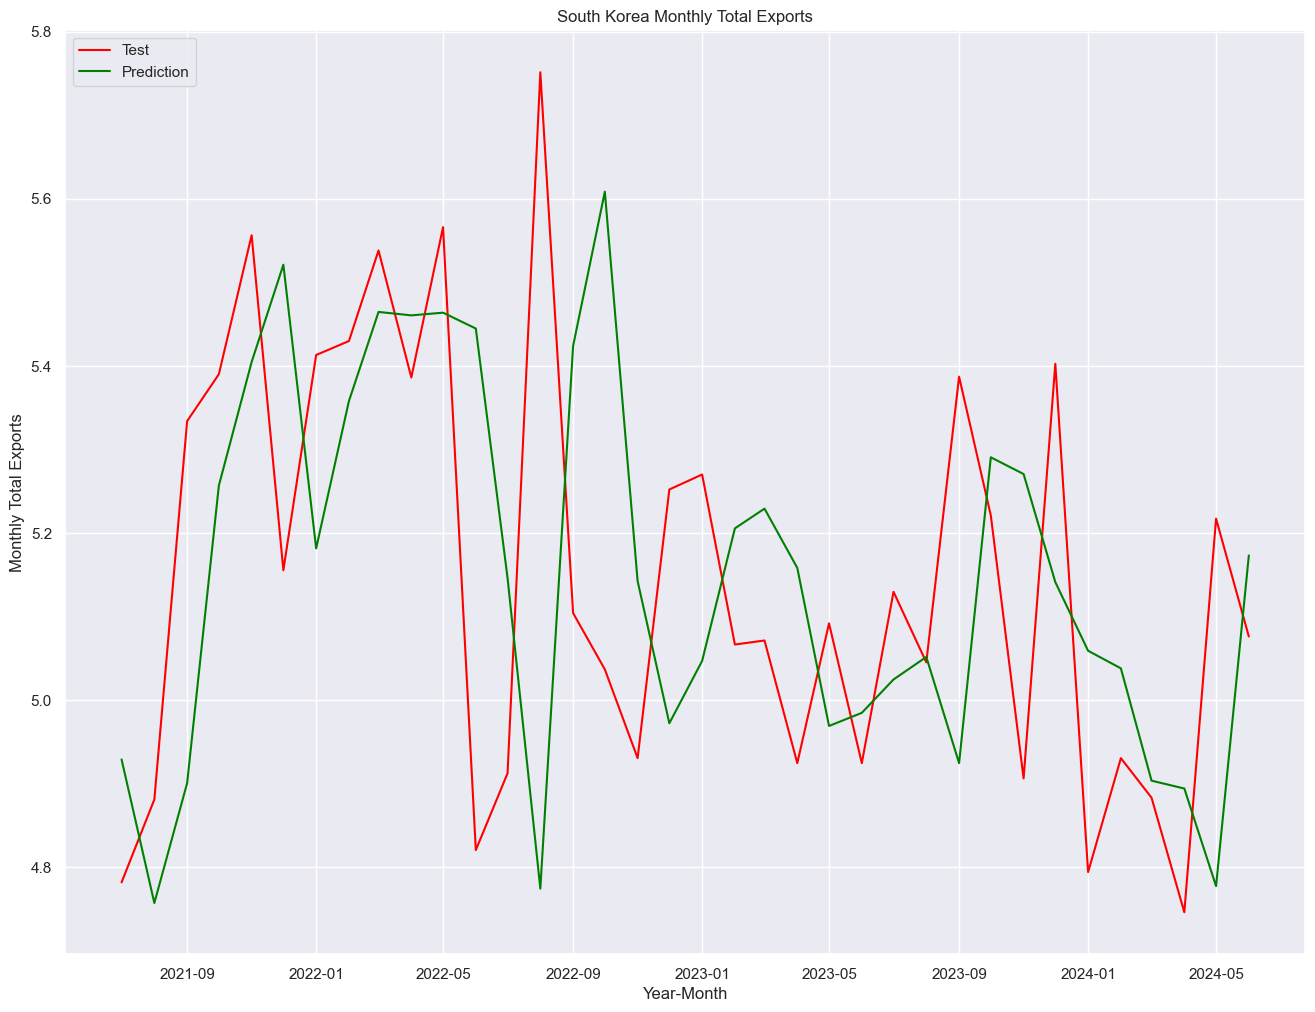

Mean Absolute Error: 0.2335879188366318
Mean Absolute Percent Error: 0.0451
Root Mean Squared Error: 0.3043613395940072


In [47]:
testVpred(test, AApredictions_rolling)

Evaluating the different models:

**SARIMA Model**

+ Mean Absolute Error: 0.24673541299770896

+ Mean Absolute Percent Error: 0.0479

+ Root Mean Squared Error: 0.30066259708282295

**SARIMA Rolling Model**

+ Mean Absolute Error: 0.3049676588280895

+ Mean Absolute Percent Error: 0.0593

+ Root Mean Squared Error: 0.36830465978308097

**Auto ARIMA Model**

+ Mean Absolute Error: 0.23956606130940392

+ Mean Absolute Percent Error: 0.0452

+ Root Mean Squared Error: 0.31051623187842425

**Auto ARIMA ROLLING Model**

+ Mean Absolute Error: 0.2335879188366318

+ Mean Absolute Percent Error: 0.0451

+ Root Mean Squared Error: 0.3043613395940072

By comparing the different models, we choose the Auto ARIMA Rolling Model to forecast South Korea's future total monthly exports. It has the best error statistics among all the models. 

**Best model:  ARIMA(1,1,0)(4,1,1)[12]**